# Analysis of Covid-19 data for the year 2021 - Regions

Now, the goal is to use the previous dataset for the covid-19 for the year 2021 and to reproduce the analysis performed on the paper.
A thig to consider, is that the paper analyzes data for the year 2020 considering pahse 2 as the range of days for the analysis. here, since we have data for the year 2021, we consider the beginning of the third wave instead of phase 2, that is when the Covid19- variants has begun to spread in Italy. We consider the beginning of the third wave from the 6th of march to the 25 of April. Hence, the indicators are computed considering this range of dates. For each index, a statistical analysis is computed, with graphical checks and tests to see the distributional assumptions.

To inspect the structure of the regional dataset, a 3D scatterplot is displayed.

Afterwards, a Kolmogorov-Smirnov test for normaility of the indexes is computed.

To test for correlation between the indexes, the Spearman's rank correlation coefficient is computed. Then, the linear relationship between the number of tests performed and the the prevalence of covid cases is fitted using linear regression models. Variables included in the regression models were first log transformed. 
Since data on the prevalence and trend were related to the different testing strategies between italian regions, the residuals of the linear regressions are used to adjust both indicators for the number of tests performed. Then, in order to adjust for different indicators, the values were further standardized using the Z-Score traditional formula for standardization.
Then, clusterization is performed, appliying both Hierarchical with Ward criterion and K-means clustering techniques, in order to get a confirmation of the number of clusters. 


First, the packages used for the analysis are imported
[Import packages for the analysis](#import);


Then, the dataset ready for the analysis, that has been previously analyzed and cleaned, is loaded. [Load the covid19 regional dataset for the year 2021](#load);

Afterward, it is possible to start with the analysis! Hereafter, the table of content.


### Table of content:

 1. [Creation of the Indexes](#Indexes):  
 
    1a.[Index 1:  Prevalence of Positive cases (per 10,000 Residents)](#index1);
    
    1b.[Index 2:  Trend of Positive Cases (%)](#index2);
    
    1c.[Index 3:  Number of Tests (Per 10,000 residents)](#index3);
    
    1d.[Additional Index: Prevalence positive cases at the end of april](#additionalindex);
    
    
 2. [Construction of a dataframe with only the indexes](#tablecons);
 
 
 3. [Structure of the regional dataset: 3D scatterplot](#scatterplot);
 
 
 4. [Kolmogorov-Smirnov test for Normality](#kolmogorovsmirnov);
    
    4a. [Regional Prevalence Index](#ksindex1);
    
    4b. [Weekly Trend Index](#ksindex2);
    
    4c. [Test per resident Index](#ksindex3);
    
 
 5. [Sperarman's Rank Correlation Coefficient](#srcorrcoeff);
 
 
 6. [Linear Regression Model](#linearreg);
    
    6a. [Model 1](#Model1);
    
      - [Log-transformation of the variables](#logtransf1);
      - [Model fit](#modelfit1);
      - [Rainbow Test for linearity](#rainbowtest1);
      - [Variables resiudal adjustment](#resadj1);
    
    6b. [Model2](#Model2);
    
      - [Log-transformation of the variables](#logtransf2);
      - [Model fit](#modelfit2);
      - [Rainbow Test for linearity](#rainbowtest2);
      - [Variables resiudal adjustment](#resadj2);
    
    6c. [Z-Score Standardization of the adjusted variables](#zscore);
    
    6d. [Saving the final dataset for the clusterization](#finaldataset);
    
    
 7. [Clusterization](#clusterization);
    
    7a. [Hierarchical Clusterization](#hierarchical);
       
       - [General scatterplot](#generalscatterplot);
       
       -[Dendogram](#dendogram);
       
       - [Silhouette Width](#silhouettewidth);
     
    7b. [K-Means](#kmeans);
    
       - [For 2 clusters](#2clusters);
       - [Inertia and Silhouette Width graph](#InertiaSilhouette);
       - [K-Means cluster plots](#Kmeansclusterplot);
       - [Knee Locator](#KneeLocator).
       
    7c. [Kruscal Wallis Test for intra-cluster variability](#KruscalWallis);
    
       
 8. [Final Considerations](#finalconsid)

<a class="anchor" id="import"></a>
### Import the packages for the analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import create_load_conf_files as conf
%matplotlib inline
sns.set(color_codes=True)
import os
from save_dataframes import save_dataframes
import warnings
warnings.filterwarnings('ignore')

#statistical analysis
from scipy import stats
#scatterplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
#linear regression models
import statsmodels.api as sm
from patsy import dmatrices

#clusterization
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
RESULT = "../results"
PLOTS = "../plots"
DATA = "../data"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#hierarchical clusterization
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering

#for kmeans
from sklearn.cluster import KMeans

#conda install -c conda-forge kneed 
from kneed import KneeLocator


<a class="anchor" id="load"></a>

### Load the covid-19 regional dataset for the year 2021
First thing to do is to load the dataset "covid_regions_2021_final" that has been previously cleaned and it is ready for the analysis.

In [2]:
covid_regions_2021=pd.read_csv("../Results/covid_regions_2021_final.csv")

In [3]:
covid_regions_2021.head()

Date  Region_code     Region_name  Hospitalyzed_symptoms  \
0  2021-01-01 17:00:00           13         Abruzzo                    435   
1  2021-01-01 17:00:00           17      Basilicata                     83   
2  2021-01-01 17:00:00           18        Calabria                    233   
3  2021-01-01 17:00:00           15        Campania                   1359   
4  2021-01-01 17:00:00            8  Emilia-Romagna                   2643   

   Intensive_care  Total_hospitalized  Home_isolation  Total_positive  \
0              38                 473           10900           11373   
1               5                  88            6053            6141   
2              18                 251            8612            8863   
3             104                1463           76865           78328   
4             231                2874           53913           56787   

   Total_positive_variation  New_positive  ...  Total_cases  swab_tests  \
0                       300           410  ...        35723      519874   
1                        90           156  ...        10982      185256   
2                        46           345  ...        24265      442569   
3                      1073          1734  ...       191407     2055822   
4                      -559          2629  ...       174141     2583512   

   Test_cases  Intensive_care_entrance  Total_positive_molecular_test  \
0    270995.0                      3.0                            0.0   
1    118358.0                      1.0                            0.0   
2    423838.0                      3.0                            0.0   
3   1375469.0                     19.0                            0.0   
4   1232042.0                     11.0                            0.0   

   Total_positive_rapid_test  Molecular_swab_test  Rapid_swab_text  Year  \
0                        0.0                  0.0              0.0  2021   
1                        0.0                  0.0              0.0  2021   
2                        0.0                  0.0              0.0  2021   
3                        0.0                  0.0              0.0  2021   
4                        0.0                  0.0              0.0  2021   

   Total_population  
0           1285256  
1            547579  
2           1877728  
3           5679759  
4           4445549  

[5 rows x 24 columns]

<a class="anchor" id="Indexes"></a>
## 1.  Creation of the Indexes

We start by creating the indexes. 

<a class="anchor" id="index1"></a>
#### 1a. Index 1:  Prevalence of Positive cases (per 10,000 Residents)

The first index that is created is the one fo the regional prevalence of SARS-CoV-2 positive cases on 6th of March 2021, that we call Regional prevalence. 
This index is computed as the ratio between the Total Positive per region and the Total Population per region, multiplied by 10,000.

In [4]:
regional_prevalence_march2021 = pd.crosstab([covid_regions_2021['Region_name'], covid_regions_2021["Date"]=="2021-03-06 17:00:00"] ,
                                             values=10000*covid_regions_2021['Total_positive']/covid_regions_2021['Total_population'],
                                             aggfunc='sum',
                                            columns=['Prevalence of positive cases (per 10000 residents)'])
regional_prevalence_march2021.columns.name=None
a=regional_prevalence_march2021.reorder_levels(["Date","Region_name"])
regional_prevalence_march2021=a.iloc[a.index.get_level_values("Date")==True]
regional_prevalence_march2021

Prevalence of positive cases (per 10000 residents)
Date Region_name                                                              
True Abruzzo                                                       101.979683 
     Basilicata                                                     72.208759 
     Calabria                                                       35.068977 
     Campania                                                      153.937870 
     Emilia-Romagna                                                117.965183 
     Friuli Venezia Giulia                                        3558.682015 
     Lazio                                                          64.971728 
     Liguria                                                        38.812959 
     Lombardia                                                      80.921104 
     Marche                                                         68.535759 
     Molise                                                         57.090444 
     Piemonte                                                       50.208157 
     Puglia                                                         88.753788 
     Sardegna                                                       79.125280 
     Sicilia                                                        40.750889 
     Toscana                                                        56.423449 
     Trentino-Alto Adige                                          3133.506157 
     Umbria                                                         85.836860 
     Valle d'Aosta                                                  62.151967 
     Veneto                                                         58.304532

In [5]:
regional_prevalence_march2021.shape

(20, 1)

To have a graphical representation of the differences between the regions, a bar plot is displayed.

**Regional trend**

<AxesSubplot:xlabel='Date,Region_name'>

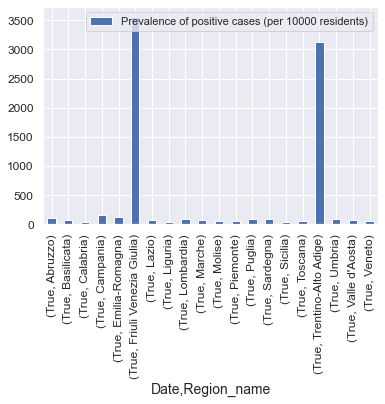

In [6]:
regional_prevalence_march2021.plot(kind="bar")

It is possible to see that Friuli Venezia Giulia and Trentino-Alto Adige are the two regions with the highest regional prevalence. All the other tegions have more or less the same prevalence. 

**Distribution**

Now we look at the distribution of the indicator variable.

<Figure size 1440x1440 with 0 Axes>

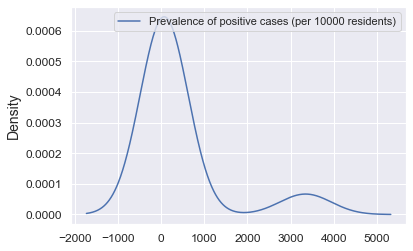

<Figure size 1440x1440 with 0 Axes>

In [7]:
regional_prevalence_march2021.plot(kind="density")
plt.legend(loc="upper right")
plt.figure(figsize=(20,20))

The distribution seems right skewed but it does not look Gaussian. It presents a long right tail, meaning that there are some extreme positive values. However, in order to have a confirmation of the non-gaussianity distributional assumption, further checks are performed. 

**Mean**

In [8]:
mean=np.nanmean(regional_prevalence_march2021)
mean

400.2617779724661

**Variance**

In [9]:
variance=np.var(regional_prevalence_march2021)
variance

Prevalence of positive cases (per 10000 residents)    969485.550323
dtype: float64

**Skewness**

In [10]:
skewness=stats.skew(regional_prevalence_march2021, nan_policy="omit")
skewness

array([2.68604027])

For normally distributed data, the skewness should be around 0. Here we have 2.68 so the distribution is not normal and it is not symmetric. Additionally, to test whether we have a normal distribution, we can test the null ypothesis that the skewness of the population is the same as that of a corresponding normal distribution.

In [11]:
skewtest=stats.skewtest(regional_prevalence_march2021, nan_policy="omit")
skewtest

SkewtestResult(statistic=array([4.28541549]), pvalue=array([1.82397976e-05]))

The p-value is sigificant so we can reject the null hypothesis that the distribution is normal.

Given the previous results, we can conclude that the normality assumption for the distribution of the Total_positive cases indicator is not Gaussian.

<a class="anchor" id="index2"></a>
#### 1b. Index 2:  Trend of Positive Cases (%) 

The second index is the weekly regional trend of SARS-CoV-2 positive cases from 30 March to 6 April 2021, since it is the week before the beginning of the third wave. The index is computed as the ratio between the Total Positive variation and the Total Population,  multiplied by 100. It is expressed as the percentage of increment/decrement of positive cases. 

In [12]:
weekly_reg_prevalence_2021 = pd.crosstab([covid_regions_2021['Region_name'], (covid_regions_2021["Date"]>="2021-03-30 17:00:00")&(covid_regions_2021["Date"]<="2021-04-06 17:00:00")] ,
                                             values=covid_regions_2021['Total_positive_variation']/covid_regions_2021["Total_population"]*100,
                                             aggfunc='sum',
                                            columns=['Trend of positive cases (%)'])
weekly_reg_prevalence_2021.columns.name=None
c=weekly_reg_prevalence_2021.reorder_levels(["Date","Region_name"])
weekly_reg_prevalence_2021=c.iloc[c.index.get_level_values("Date")==True]
weekly_reg_prevalence_2021

Trend of positive cases (%)
Date Region_name                                       
True Abruzzo                                   0.000700
     Basilicata                                0.023376
     Calabria                                  0.061990
     Campania                                 -0.063929
     Emilia-Romagna                           -0.067483
     Friuli Venezia Giulia                    -6.650831
     Lazio                                     0.040991
     Liguria                                   0.065505
     Lombardia                                -0.121461
     Marche                                   -0.065139
     Molise                                   -0.094083
     Piemonte                                 -0.070135
     Puglia                                    0.100842
     Sardegna                                  0.116317
     Sicilia                                   0.145325
     Toscana                                   0.032413
     Trentino-Alto Adige                      -2.990927
     Umbria                                   -0.058034
     Valle d'Aosta                             1.275373
     Veneto                                   -0.054776

In [13]:
weekly_reg_prevalence_2021.shape

(20, 1)

**Weekly regional trend**

<AxesSubplot:xlabel='Date,Region_name'>

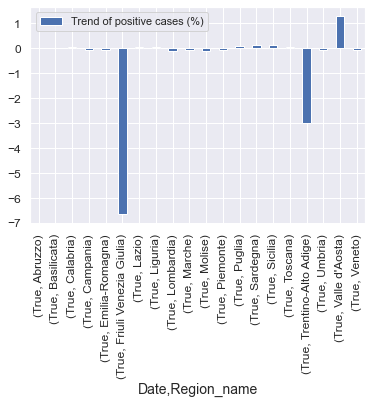

In [14]:
weekly_reg_prevalence_2021.plot(kind="bar")

It is possible to notice that Friuli Venezia Giulia and Trentino alto adige are the Regions with the highest negative weekly prevalence, meaning that they are the regions with the highest decrement of positive cases, from the week before the beginning of the third wave. Valle d'Aosta is the region with the highest increment of positive cases the week before the beginning of the third wave. 

**Distribution**

Now we look at the distribution of the indicator variable:

<AxesSubplot:ylabel='Density'>

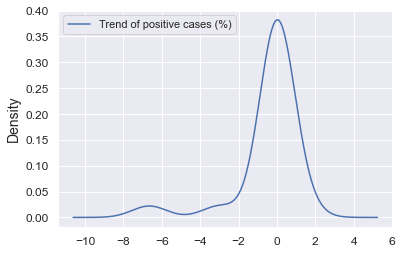

In [15]:
weekly_reg_prevalence_2021.plot(kind="density")
plt.legend(loc="upper left")
plt.figure(figsize=(20,20))

The distribution seems centered around zero, however it does not look gaussian. Moreover, it is not symmetric since it has a long left tail, meaning that there are extreme negative values, coherent with the barplot displayed above. 

Now we compute some statistics to validate our assumption.

**Mean**

In [16]:
mean=np.nanmean(weekly_reg_prevalence_2021)
mean

-0.41869836223410173

The mean of the distribution is negative, this is due to the inlfuence of the two regions which presents high negative values. Indeed the mean of the distribution is highly sensible to outliers, and the two regions can be considered as such. 

**Variance**

In [17]:
variance=np.var(weekly_reg_prevalence_2021)
variance

Trend of positive cases (%)    2.570181
dtype: float64

**Skewness**

In [18]:
skewness=stats.skew(weekly_reg_prevalence_2021, nan_policy="omit")
skewness

array([-3.06802325])

The skewness in not zero, hence the distribution is not a standard gaussian.

We compute also the skewness test to have a further confirmation.

In [19]:
skewtest=stats.skewtest(weekly_reg_prevalence_2021, nan_policy="omit")
skewtest

SkewtestResult(statistic=array([-4.63604654]), pvalue=array([3.55136047e-06]))

Even here the p-value is significant, hence we can reject the null hypothesis of the normality distribution of the indicator. 

<a class="anchor" id="index3"></a>
#### 1c. Index 3:  Number of Tests (Per 10,000 residents) 

The third and final index is the number of tests performed per 10,000 residents. This index is considered only at regional levels. It is computed as the reatio between the number of swab tests per region and the total population per region, multiplied by 10,000.

In [20]:
Tests_per_residents2021 = pd.crosstab(covid_regions_2021['Region_name'] ,
                                             values=covid_regions_2021['swab_tests']/covid_regions_2021['Total_population']*10000,
                                             aggfunc='sum',
                                            columns=['Number of tests performed ( per 10000 residents)'])
Tests_per_residents2021.columns.name=None
Tests_per_residents2021

Number of tests performed ( per 10000 residents)
Region_name                                                            
Abruzzo                                                    1.373429e+06
Basilicata                                                 8.150788e+05
Calabria                                                   5.532965e+05
Campania                                                   9.656197e+05
Emilia-Romagna                                             1.601497e+06
Friuli Venezia Giulia                                      7.368918e+07
Lazio                                                      1.348825e+06
Liguria                                                    1.237454e+06
Lombardia                                                  1.233615e+06
Marche                                                     9.851834e+05
Molise                                                     9.509713e+05
Piemonte                                                   1.150771e+06
Puglia                                                     7.260967e+05
Sardegna                                                   9.060112e+05
Sicilia                                                    9.612543e+05
Toscana                                                    1.412858e+06
Trentino-Alto Adige                                        8.444493e+07
Umbria                                                     1.707247e+06
Valle d'Aosta                                              5.314073e+06
Veneto                                                     1.889961e+06

In [21]:
Tests_per_residents2021.shape

(20, 1)

**Regional trend**

<AxesSubplot:xlabel='Region_name'>

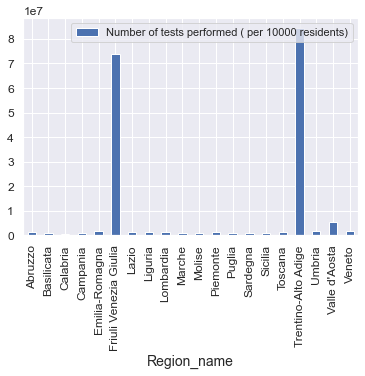

In [22]:
Tests_per_residents2021.plot(kind="bar")

From the plot above it results that Friuli Venezia Giulia and Trentino-Alto Adige are the two regions with the higest number of tests performed. This is coherent with the results found in the bar plot for the total Positive index, since if the number of tests is performed, the more the number of positives increases. 

**Distribution**

<Figure size 1440x1440 with 0 Axes>

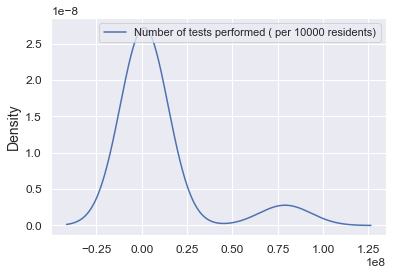

<Figure size 1440x1440 with 0 Axes>

In [105]:
Tests_per_residents2021. plot(kind="density")
plt.legend(loc="upper right")
plt.figure(figsize=(20,20))

The distribution seems right skewed and it does not look Gaussian. Moreover there is a long right tail, indicating that there are some positive extreme values. 

**Mean**

In [24]:
mean=np.nanmean(Tests_per_residents2021)
mean

9163367.718559641

**Variance**

In [25]:
variance=np.var(Tests_per_residents2021)
variance

Number of tests performed ( per 10000 residents)    5.467558e+14
dtype: float64

**Skewness**

In [26]:
skewness=stats.skew(Tests_per_residents2021, nan_policy="omit")
skewness

array([2.68485329])

The skewness is not zer, hence the distribution is not a standard gaussian. We perform additional checks to see whether the gaussian distributional assumption is rejected or not.

In [27]:
skewtest=stats.skewtest(Tests_per_residents2021, nan_policy="omit")
skewtest

SkewtestResult(statistic=array([4.28426335]), pvalue=array([1.83345638e-05]))

The p-value is significant, hence we can reject the null hypothesis of a gaussian distribution.

<a class="anchor" id="additionalindex"></a>
#### 1d. Additional index: Prevalence positive cases at the end of april

An additiona indicator that it is intersting to check is the regional prevalence of covid positive cases at the end of the third wave, to see whether there has been a change in the regional trends and if the extreme regions have changed. As for the first index, we consider the the 25 of April as the end of the third wave. This index will not be used for clusterization.

In [28]:
regional_prevalence_endapril2021 = pd.crosstab([covid_regions_2021['Region_name'], covid_regions_2021["Date"]=="2021-05-25 17:00:00"] ,
                                             values=10000*covid_regions_2021['Total_positive']/covid_regions_2021['Total_population'],
                                             aggfunc='sum',
                                            columns=['Prevalence of positive cases (per 10000 residents)'])
regional_prevalence_endapril2021.columns.name=None
b=regional_prevalence_endapril2021.reorder_levels(["Date","Region_name"])
regional_prevalence_endapril2021=b.iloc[b.index.get_level_values("Date")==True]
regional_prevalence_endapril2021

Prevalence of positive cases (per 10000 residents)
Date Region_name                                                              
True Abruzzo                                                        45.313930 
     Basilicata                                                     79.002299 
     Calabria                                                       56.440549 
     Campania                                                      123.989416 
     Emilia-Romagna                                                 40.089537 
     Friuli Venezia Giulia                                        1564.346184 
     Lazio                                                          43.964162 
     Liguria                                                        10.319213 
     Lombardia                                                      34.692513 
     Marche                                                         29.785414 
     Molise                                                          6.171029 
     Piemonte                                                       16.851500 
     Puglia                                                         78.007482 
     Sardegna                                                       82.472743 
     Sicilia                                                        26.036610 
     Toscana                                                        28.421629 
     Trentino-Alto Adige                                           428.710305 
     Umbria                                                         22.149956 
     Valle d'Aosta                                                  92.689061 
     Veneto                                                         21.702426

**Regional Trend**

<AxesSubplot:xlabel='Date,Region_name'>

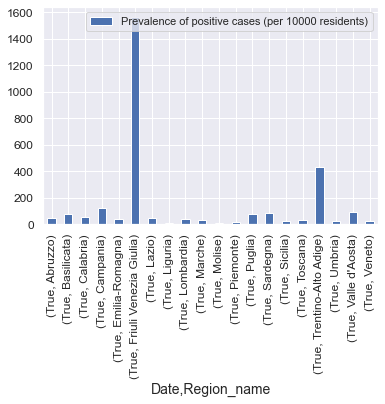

In [29]:
regional_prevalence_endapril2021.plot(kind="bar")

Friuli Venezia Giulia still has a high regional prevalence of positive cases, but it is decreased a bit, whereas Trentino-Alto Adige has decreased a lot.

<a class="anchor" id="tablecons"></a>


### Construction of a dataframe with only the indexes

Now we construct a dataframe containing only the indexes, since they are the only variables which will be used for the cluster analysis.  We first need to transform each cross tab into a dataframe. 

**Frist dataframe**

In [30]:
regional_prev_df = regional_prevalence_march2021.add_prefix('').reset_index().rename_axis(None, axis=1) 
regional_prev_df=regional_prev_df.drop(columns=["Date"])
regional_prev_df

Region_name  Prevalence of positive cases (per 10000 residents)
0                 Abruzzo                                         101.979683 
1              Basilicata                                          72.208759 
2                Calabria                                          35.068977 
3                Campania                                         153.937870 
4          Emilia-Romagna                                         117.965183 
5   Friuli Venezia Giulia                                        3558.682015 
6                   Lazio                                          64.971728 
7                 Liguria                                          38.812959 
8               Lombardia                                          80.921104 
9                  Marche                                          68.535759 
10                 Molise                                          57.090444 
11               Piemonte                                          50.208157 
12                 Puglia                                          88.753788 
13               Sardegna                                          79.125280 
14                Sicilia                                          40.750889 
15                Toscana                                          56.423449 
16    Trentino-Alto Adige                                        3133.506157 
17                 Umbria                                          85.836860 
18          Valle d'Aosta                                          62.151967 
19                 Veneto                                          58.304532

**Second dataframe**

In [31]:
weekly_re_prev_df=weekly_reg_prevalence_2021.add_prefix("").reset_index().rename_axis(None, axis=1) 
weekly_re_prev_df=weekly_re_prev_df.drop(columns=["Date"])
weekly_re_prev_df

Region_name  Trend of positive cases (%)
0                 Abruzzo                     0.000700
1              Basilicata                     0.023376
2                Calabria                     0.061990
3                Campania                    -0.063929
4          Emilia-Romagna                    -0.067483
5   Friuli Venezia Giulia                    -6.650831
6                   Lazio                     0.040991
7                 Liguria                     0.065505
8               Lombardia                    -0.121461
9                  Marche                    -0.065139
10                 Molise                    -0.094083
11               Piemonte                    -0.070135
12                 Puglia                     0.100842
13               Sardegna                     0.116317
14                Sicilia                     0.145325
15                Toscana                     0.032413
16    Trentino-Alto Adige                    -2.990927
17                 Umbria                    -0.058034
18          Valle d'Aosta                     1.275373
19                 Veneto                    -0.054776

**Third dataframe**

In [32]:
test_per_residents_df=Tests_per_residents2021.add_prefix("").reset_index().rename_axis(None, axis=1) 
test_per_residents_df

Region_name  Number of tests performed ( per 10000 residents)
0                 Abruzzo                                      1.373429e+06
1              Basilicata                                      8.150788e+05
2                Calabria                                      5.532965e+05
3                Campania                                      9.656197e+05
4          Emilia-Romagna                                      1.601497e+06
5   Friuli Venezia Giulia                                      7.368918e+07
6                   Lazio                                      1.348825e+06
7                 Liguria                                      1.237454e+06
8               Lombardia                                      1.233615e+06
9                  Marche                                      9.851834e+05
10                 Molise                                      9.509713e+05
11               Piemonte                                      1.150771e+06
12                 Puglia                                      7.260967e+05
13               Sardegna                                      9.060112e+05
14                Sicilia                                      9.612543e+05
15                Toscana                                      1.412858e+06
16    Trentino-Alto Adige                                      8.444493e+07
17                 Umbria                                      1.707247e+06
18          Valle d'Aosta                                      5.314073e+06
19                 Veneto                                      1.889961e+06

Then, we merged the three dataframes into a single one.

In [33]:
df1=pd.merge(regional_prev_df, weekly_re_prev_df, on="Region_name")
df1

Region_name  Prevalence of positive cases (per 10000 residents)  \
0                 Abruzzo                                         101.979683    
1              Basilicata                                          72.208759    
2                Calabria                                          35.068977    
3                Campania                                         153.937870    
4          Emilia-Romagna                                         117.965183    
5   Friuli Venezia Giulia                                        3558.682015    
6                   Lazio                                          64.971728    
7                 Liguria                                          38.812959    
8               Lombardia                                          80.921104    
9                  Marche                                          68.535759    
10                 Molise                                          57.090444    
11               Piemonte                                          50.208157    
12                 Puglia                                          88.753788    
13               Sardegna                                          79.125280    
14                Sicilia                                          40.750889    
15                Toscana                                          56.423449    
16    Trentino-Alto Adige                                        3133.506157    
17                 Umbria                                          85.836860    
18          Valle d'Aosta                                          62.151967    
19                 Veneto                                          58.304532    

    Trend of positive cases (%)  
0                      0.000700  
1                      0.023376  
2                      0.061990  
3                     -0.063929  
4                     -0.067483  
5                     -6.650831  
6                      0.040991  
7                      0.065505  
8                     -0.121461  
9                     -0.065139  
10                    -0.094083  
11                    -0.070135  
12                     0.100842  
13                     0.116317  
14                     0.145325  
15                     0.032413  
16                    -2.990927  
17                    -0.058034  
18                     1.275373  
19                    -0.054776

**Final dataframe**

In [34]:
regions_indexes_df=pd.merge(df1, test_per_residents_df, on="Region_name")
regions_indexes_df

Region_name  Prevalence of positive cases (per 10000 residents)  \
0                 Abruzzo                                         101.979683    
1              Basilicata                                          72.208759    
2                Calabria                                          35.068977    
3                Campania                                         153.937870    
4          Emilia-Romagna                                         117.965183    
5   Friuli Venezia Giulia                                        3558.682015    
6                   Lazio                                          64.971728    
7                 Liguria                                          38.812959    
8               Lombardia                                          80.921104    
9                  Marche                                          68.535759    
10                 Molise                                          57.090444    
11               Piemonte                                          50.208157    
12                 Puglia                                          88.753788    
13               Sardegna                                          79.125280    
14                Sicilia                                          40.750889    
15                Toscana                                          56.423449    
16    Trentino-Alto Adige                                        3133.506157    
17                 Umbria                                          85.836860    
18          Valle d'Aosta                                          62.151967    
19                 Veneto                                          58.304532    

    Trend of positive cases (%)  \
0                      0.000700   
1                      0.023376   
2                      0.061990   
3                     -0.063929   
4                     -0.067483   
5                     -6.650831   
6                      0.040991   
7                      0.065505   
8                     -0.121461   
9                     -0.065139   
10                    -0.094083   
11                    -0.070135   
12                     0.100842   
13                     0.116317   
14                     0.145325   
15                     0.032413   
16                    -2.990927   
17                    -0.058034   
18                     1.275373   
19                    -0.054776   

    Number of tests performed ( per 10000 residents)  
0                                       1.373429e+06  
1                                       8.150788e+05  
2                                       5.532965e+05  
3                                       9.656197e+05  
4                                       1.601497e+06  
5                                       7.368918e+07  
6                                       1.348825e+06  
7                                       1.237454e+06  
8                                       1.233615e+06  
9                                       9.851834e+05  
10                                      9.509713e+05  
11                                      1.150771e+06  
12                                      7.260967e+05  
13                                      9.060112e+05  
14                                      9.612543e+05  
15                                      1.412858e+06  
16                                      8.444493e+07  
17                                      1.707247e+06  
18                                      5.314073e+06  
19                                      1.889961e+06

This dataset is the one that will be used to conduct the analysis.


We save it in the Results folder.

In [35]:
path="../Results/regions_indexes_df.csv"

save_dataframes(regions_indexes_df, path)

<a class="anchor" id="scatterplot"></a>

## Structure of the regional dataset: 3D scatterplot

Now we inspect the structure of the regional dataset by using a three-dimensional scatterpot.

In [37]:
labels=regions_indexes_df["Region_name"].unique()
print(labels)

['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia' 'Toscana' 'Trentino-Alto Adige'
 'Umbria' "Valle d'Aosta" 'Veneto']


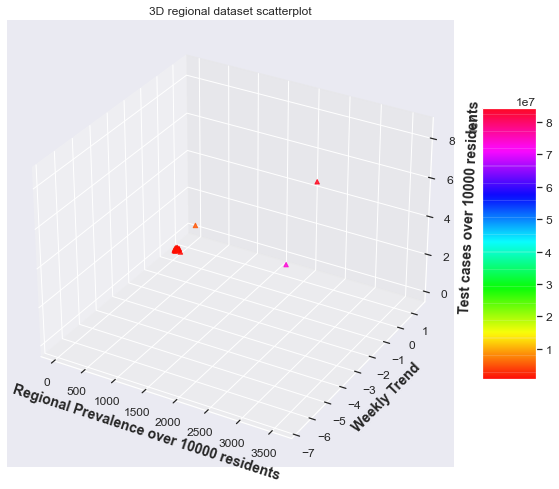

In [38]:
#creating figure
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection="3d")

#add x and y gridlines
ax.grid(b=True, color="grey", linestyle="-.", linewidth=0.3, alpha=0.2)
#creating color map
my_colmap=plt.get_cmap("hsv")

#creating plot
#x=regions_indexes_df["Prevalence of positive cases (per 10000 residents)"]
#y=regions_indexes_df["Trend of positive cases (%)"]
#z=regions_indexes_df["Number of tests performed ( per 10000 residents)"]
x=regions_indexes_df.iloc[:,1]
y=regions_indexes_df.iloc[:,2]
z=regions_indexes_df.iloc[:,3]
scatterplot_regions=ax.scatter3D(x,y,z,
                  alpha = 0.8,
                  c = (x + y + z),
                  cmap = my_colmap,
                  marker ='^')

plt.title("3D regional dataset scatterplot")
ax.set_xlabel('Regional Prevalence over 10000 residents', fontweight ='bold')
ax.set_ylabel('Weekly Trend ', fontweight ='bold')
ax.set_zlabel('Test cases over 10000 residents', fontweight ='bold')
fig.colorbar(scatterplot_regions, ax = ax, shrink = 0.5, aspect = 5)
 
# saving plot
plt.savefig("../plots/3d_scatter_plot_regions.pdf", bbox_inches="tight")

Even from the plot above it is possible to have a rough cluster visualization. If we consider the points with the same color as units belonging to the same cluster, we can see that there is a big cluster, composed by the red dots which are the only points closer to each other. The cluster of red dots has one outlier which corresponds to the region with a high level of Tests cases over 10000 residents. The orange and the pink dot are far from the red cluster and they are a cluster of one variable only. 

<a class="anchor" id="kolmogorovsmirnov"></a>

## Kolmogorov-Smirnov test for Normality

Now we can test for normality of the indices by performing a Kolmogorov-Smirnov test.
A brief recall of what the Kolmogorov-Smirnov test does:
The null hypothesis H0 is that the distribution of our data is equat to the standard normal distribution with mean 0 ans standard deviation 1. A p-value less than 5% would indicate that the data are not following a standard gaussian distribution.

<a class="anchor" id="ksindex1"></a>
#### Regional Prevalence Index

In [39]:
stats.kstest(regional_prevalence_march2021,"norm")

KstestResult(statistic=1.0, pvalue=0.0)

The null hypothesis is rejected. To check whether our values are gaussian we can do the following:

In [40]:
data=regional_prevalence_march2021
normed_data=(data-data.mean())/data.std()
stats.kstest(normed_data,"norm")

KstestResult(statistic=0.9991155540620082, pvalue=1.715757197248568e-61)

The data do not follow a Gaussian distribution.

<a class="anchor" id="ksindex2"></a>
#### Weekly Trend Index

In [41]:
stats.kstest(weekly_reg_prevalence_2021,"norm")

KstestResult(statistic=0.9999999999854279, pvalue=3.728082738292163e-217)

Even here the null hypothesis is rejected.

In [42]:
data=weekly_reg_prevalence_2021
normed_data=(data-data.mean())/data.std()
stats.kstest(normed_data,"norm")

KstestResult(statistic=0.9999243515009627, pvalue=7.534185441339998e-83)

<a class="anchor" id="ksindex3"></a>
#### Tests per residents Index

In [43]:
stats.kstest(Tests_per_residents2021,"norm")

KstestResult(statistic=1.0, pvalue=0.0)

H0 rejected.

In [44]:
data=Tests_per_residents2021
normed_data=(data-data.mean())/data.std()
stats.kstest(normed_data,"norm")

KstestResult(statistic=0.9991494920099153, pvalue=7.845090437870829e-62)

In all the indices the normality assumption is rejected. Indeed if we look at the density plot of the indicators they do not look normally distributed.

<a class="anchor" id="srcorrcoeff"></a>
## Spearman Rank Correlation Coefficient
The Spearman's rank correlation coefficient is a non-parametric procedure for correlation. It is used to measure the degree of relation between two variables. the only requirement on the variables is that they must be ordered and continuous. 
The null hypothesis is that the correlation is significantly different from zero, since a correlation of zero would indicate that there is no trend in the dependent variable to increase or decrease as the independent variable increases.


In [45]:
#between regional_prevalence index and weekly regional trend
stats.spearmanr(regional_prevalence_march2021,weekly_reg_prevalence_2021, axis=0, nan_policy="omit")

SpearmanrResult(correlation=-0.4781954887218045, pvalue=0.032950383214957614)

The correlation is negative, this implies that as x increases, then y decreases. The p-value is significant, hence, the correlation is not statistically different from zero, suggesting that it is very low.

In [46]:
#between regional prevalence index and number of tests performed
stats.spearmanr(regional_prevalence_march2021,Tests_per_residents2021, axis=0, nan_policy="omit")

SpearmanrResult(correlation=0.35639097744360904, pvalue=0.12298631080226882)

Here the correlation is positive, so it means that as x increases so does y. And the p-value is not significant, meaning that the correlation is quite strong.

In [47]:
#between weekly regional trend and number of tests performed.
stats.spearmanr(weekly_reg_prevalence_2021,Tests_per_residents2021, axis=0, nan_policy="omit")

SpearmanrResult(correlation=-0.3533834586466165, pvalue=0.12640665077932206)

Here the correlation is negative, so as x increases, y decreases. But the p-value is not significant.

<a class="anchor" id="linearreg"></a>

## Linear Regression Model

Now we can test the linear relationship of the number of tests performed per 10000 residents (x) with the prevalence or trend of covid cases (y) using OLS.

<a class="anchor" id="Model1"></a>
### Model 1

First, we have to log-transform the variables.

<a class="anchor" id="logtransf1"></a>
#### Log-transformation of the variables

In [48]:
logPrevalence=np.log(regional_prevalence_march2021)
logPrevalence.describe()

Prevalence of positive cases (per 10000 residents)
count                                          20.000000 
mean                                            4.607748 
std                                             1.253290 
min                                             3.557317 
25%                                             4.041699 
50%                                             4.253458 
75%                                             4.520593 
max                                             8.177146

In [49]:
logTests=np.log(Tests_per_residents2021)
logTests.describe()

Number of tests performed ( per 10000 residents)
count                                         20.000000
mean                                          14.426485
std                                            1.363699
min                                           13.223649
25%                                           13.773306
50%                                           14.027013
75%                                           14.302435
max                                           18.251610

<a class="anchor" id="modelfit1"></a>
#### Model Fit 

To fit the models covered by statsmodel library, we need to creeate two design matrices characterized by two elements:
1. the first is a matrix of endogenous variables;
2. the second is a matrix of exogenous variables.
In our case bot y and x are column vestors.

For the sake of semplicity, the column names of the dataframe regions_indexes_df are modified

In [50]:
regions_indexes_df.columns= ["Region_name","regional_prevalence_march2021","weekly_reg_prevalence_2021","Tests_per_residents2021"]
regions_indexes_df

Region_name  regional_prevalence_march2021  \
0                 Abruzzo                     101.979683   
1              Basilicata                      72.208759   
2                Calabria                      35.068977   
3                Campania                     153.937870   
4          Emilia-Romagna                     117.965183   
5   Friuli Venezia Giulia                    3558.682015   
6                   Lazio                      64.971728   
7                 Liguria                      38.812959   
8               Lombardia                      80.921104   
9                  Marche                      68.535759   
10                 Molise                      57.090444   
11               Piemonte                      50.208157   
12                 Puglia                      88.753788   
13               Sardegna                      79.125280   
14                Sicilia                      40.750889   
15                Toscana                      56.423449   
16    Trentino-Alto Adige                    3133.506157   
17                 Umbria                      85.836860   
18          Valle d'Aosta                      62.151967   
19                 Veneto                      58.304532   

    weekly_reg_prevalence_2021  Tests_per_residents2021  
0                     0.000700             1.373429e+06  
1                     0.023376             8.150788e+05  
2                     0.061990             5.532965e+05  
3                    -0.063929             9.656197e+05  
4                    -0.067483             1.601497e+06  
5                    -6.650831             7.368918e+07  
6                     0.040991             1.348825e+06  
7                     0.065505             1.237454e+06  
8                    -0.121461             1.233615e+06  
9                    -0.065139             9.851834e+05  
10                   -0.094083             9.509713e+05  
11                   -0.070135             1.150771e+06  
12                    0.100842             7.260967e+05  
13                    0.116317             9.060112e+05  
14                    0.145325             9.612543e+05  
15                    0.032413             1.412858e+06  
16                   -2.990927             8.444493e+07  
17                   -0.058034             1.707247e+06  
18                    1.275373             5.314073e+06  
19                   -0.054776             1.889961e+06

In [51]:
#the prevalence or trend of covid is a function of the number of tests performed
logPrevalence,logTests=dmatrices("regional_prevalence_march2021 ~ Tests_per_residents2021",data=regions_indexes_df,return_type="dataframe")

In [52]:
mod1=sm.OLS(logPrevalence,logTests)
mod1

In [53]:
#the degrees of freedom
mod1.df_model

1.0

In [54]:
#the degrees of freedom of the residuals
mod1.df_resid

18.0

In [55]:
#the endogenous name y
mod1.endog_names

'regional_prevalence_march2021'

In [56]:
#the exogenous name x
mod1.exog_names

['Intercept', 'Tests_per_residents2021']

In [57]:
#apply the fit function to determine the line of best fit
res1=mod1.fit() #model results
res1.params

Intercept                  18.728508
Tests_per_residents2021     0.000042
dtype: float64

In [58]:
print(res1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     regional_prevalence_march2021   R-squared:                       0.978
Model:                                       OLS   Adj. R-squared:                  0.976
Method:                            Least Squares   F-statistic:                     789.3
Date:                           Fri, 11 Jun 2021   Prob (F-statistic):           2.55e-16
Time:                                   18:38:52   Log-Likelihood:                -128.19
No. Observations:                             20   AIC:                             260.4
Df Residuals:                                 18   BIC:                             262.4
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

In [59]:
res1.summary() #another way of visualizing it

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     regional_prevalence_march2021   R-squared:                       0.978
Model:                                       OLS   Adj. R-squared:                  0.976
Method:                            Least Squares   F-statistic:                     789.3
Date:                           Fri, 11 Jun 2021   Prob (F-statistic):           2.55e-16
Time:                                   18:38:52   Log-Likelihood:                -128.19
No. Observations:                             20   AIC:                             260.4
Df Residuals:                                 18   BIC:                             262.4
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  18.7285     37.221      0.503      0.621     -59.470      96.927
Tests_per_residents2021  4.164e-05   1.48e-06     28.094      0.000    3.85e-05    4.48e-05
==============================================================================
Omnibus:                       12.490   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               23.496
Skew:                           0.561   Prob(JB):                     7.90e-06
Kurtosis:                       8.190   Cond. No.                     2.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a class="anchor" id="rainbowtest1"></a>
#### Rainbow Test for linearity
To check whether the relationship is really linear (i.e. linearity in the prarameters), we apply the Rainbow test

In [60]:
sm.stats.linear_rainbow(res1)

(79.81580778048671, 6.575636685627386e-07)

The output produces an F-test statistics and the p-value. The null hypothesis is that the fit of the model using the full sample is just the same as using a central subset. The alternative is that the fits are different. Moreover, the tests assumes that the residuals are homoskedastic and may reject a correct linear relationship if residuals are heteroskedastic.
In this case the p-value rejects the null hypothesis so we can say that the relationship is not linear. So the regional prevalence should not be expressed as a linear function of the Tests performed per resident. The parameters are not linear, maybe a polynomial model should be fitted instead.

<a class="anchor" id="resadj1"></a>
#### Variables residual adjustment

Since data on the prevalence and trend of covid positive cases were related to different testing strategies between the italian regions, residuals of the linear regression were used to adjust the regional prevalence indicator for the number of tests performed per 10000 residents. 

In [61]:
regions_indexes_df["adjusted_nr1_mod"]=logPrevalence+mod1.df_resid
regions_indexes_df["adjusted_nr1_mod"]

0      119.979683
1       90.208759
2       53.068977
3      171.937870
4      135.965183
5     3576.682015
6       82.971728
7       56.812959
8       98.921104
9       86.535759
10      75.090444
11      68.208157
12     106.753788
13      97.125280
14      58.750889
15      74.423449
16    3151.506157
17     103.836860
18      80.151967
19      76.304532
Name: adjusted_nr1_mod, dtype: float64

<a class="anchor" id="Model2"></a>
### Model 2

First, we have to log-transform the variables.

<a class="anchor" id="logtransf2"></a>
#### Log-transformation of the variables

In [62]:
logTrend=np.log(weekly_reg_prevalence_2021)
logTrend.describe()

Trend of positive cases (%)
count                    10.000000
mean                     -2.928135
std                       1.883613
min                      -7.264074
25%                      -3.370509
50%                      -2.753206
75%                      -2.187130
max                       0.243238

<a class="anchor" id="modelfit2"></a>
#### Model Fit 

In [63]:
logTrend,logTests=dmatrices("weekly_reg_prevalence_2021 ~ Tests_per_residents2021", data=regions_indexes_df, return_type="dataframe")

In [64]:
mod2=sm.OLS(logTrend,logTests)
mod2

In [65]:
#the degrees of freedom
mod2.df_model

1.0

In [66]:
#the degrees of freedom of the residuals
mod2.df_resid

18.0

In [67]:
#the endogenous name y
mod2.endog_names

'weekly_reg_prevalence_2021'

In [68]:
#apply the fit function to determine the line of best fit
res2=mod2.fit() #model results
res2.params

Intercept                  1.338243e-01
Tests_per_residents2021   -6.029690e-08
dtype: float64

In [69]:
print(res2.summary())

                                OLS Regression Results                                
Dep. Variable:     weekly_reg_prevalence_2021   R-squared:                       0.773
Model:                                    OLS   Adj. R-squared:                  0.761
Method:                         Least Squares   F-statistic:                     61.44
Date:                        Fri, 11 Jun 2021   Prob (F-statistic):           3.27e-07
Time:                                18:38:52   Log-Likelihood:                -22.972
No. Observations:                          20   AIC:                             49.94
Df Residuals:                              18   BIC:                             51.93
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

<a class="anchor" id="rainbowtest2"></a>
#### Rainbow Test for linearity

In [70]:
sm.stats.linear_rainbow(res2)

(123.92634942085805, 1.1606231259619926e-07)

Even here the relationship is not linear.

<a class="anchor" id="resadj2"></a>
#### Variables residual adjustment

In [71]:
regions_indexes_df["adjusted_nr2_mod"]=logTrend+mod2.df_resid
regions_indexes_df["adjusted_nr2_mod"]

0     18.000700
1     18.023376
2     18.061990
3     17.936071
4     17.932517
5     11.349169
6     18.040991
7     18.065505
8     17.878539
9     17.934861
10    17.905917
11    17.929865
12    18.100842
13    18.116317
14    18.145325
15    18.032413
16    15.009073
17    17.941966
18    19.275373
19    17.945224
Name: adjusted_nr2_mod, dtype: float64

In [72]:
regions_indexes_df.head()

Region_name  regional_prevalence_march2021  weekly_reg_prevalence_2021  \
0         Abruzzo                     101.979683                    0.000700   
1      Basilicata                      72.208759                    0.023376   
2        Calabria                      35.068977                    0.061990   
3        Campania                     153.937870                   -0.063929   
4  Emilia-Romagna                     117.965183                   -0.067483   

   Tests_per_residents2021  adjusted_nr1_mod  adjusted_nr2_mod  
0             1.373429e+06        119.979683         18.000700  
1             8.150788e+05         90.208759         18.023376  
2             5.532965e+05         53.068977         18.061990  
3             9.656197e+05        171.937870         17.936071  
4             1.601497e+06        135.965183         17.932517

<a class="anchor" id="zscore"></a>
## Z-Score Standardization of the adjusted variables

Now, to account for different scales between all the indicators, it is necessary to standardize the adjusted values.

In [73]:
regions_indexes_df["z1_mod"]=(regions_indexes_df.adjusted_nr1_mod - np.nanmean(regions_indexes_df["regional_prevalence_march2021"]))/np.nanstd(regions_indexes_df["regional_prevalence_march2021"])
regions_indexes_df

Region_name  regional_prevalence_march2021  \
0                 Abruzzo                     101.979683   
1              Basilicata                      72.208759   
2                Calabria                      35.068977   
3                Campania                     153.937870   
4          Emilia-Romagna                     117.965183   
5   Friuli Venezia Giulia                    3558.682015   
6                   Lazio                      64.971728   
7                 Liguria                      38.812959   
8               Lombardia                      80.921104   
9                  Marche                      68.535759   
10                 Molise                      57.090444   
11               Piemonte                      50.208157   
12                 Puglia                      88.753788   
13               Sardegna                      79.125280   
14                Sicilia                      40.750889   
15                Toscana                      56.423449   
16    Trentino-Alto Adige                    3133.506157   
17                 Umbria                      85.836860   
18          Valle d'Aosta                      62.151967   
19                 Veneto                      58.304532   

    weekly_reg_prevalence_2021  Tests_per_residents2021  adjusted_nr1_mod  \
0                     0.000700             1.373429e+06        119.979683   
1                     0.023376             8.150788e+05         90.208759   
2                     0.061990             5.532965e+05         53.068977   
3                    -0.063929             9.656197e+05        171.937870   
4                    -0.067483             1.601497e+06        135.965183   
5                    -6.650831             7.368918e+07       3576.682015   
6                     0.040991             1.348825e+06         82.971728   
7                     0.065505             1.237454e+06         56.812959   
8                    -0.121461             1.233615e+06         98.921104   
9                    -0.065139             9.851834e+05         86.535759   
10                   -0.094083             9.509713e+05         75.090444   
11                   -0.070135             1.150771e+06         68.208157   
12                    0.100842             7.260967e+05        106.753788   
13                    0.116317             9.060112e+05         97.125280   
14                    0.145325             9.612543e+05         58.750889   
15                    0.032413             1.412858e+06         74.423449   
16                   -2.990927             8.444493e+07       3151.506157   
17                   -0.058034             1.707247e+06        103.836860   
18                    1.275373             5.314073e+06         80.151967   
19                   -0.054776             1.889961e+06         76.304532   

    adjusted_nr2_mod    z1_mod  
0          18.000700 -0.284659  
1          18.023376 -0.314895  
2          18.061990 -0.352614  
3          17.936071 -0.231889  
4          17.932517 -0.268424  
5          11.349169  3.226022  
6          18.040991 -0.322245  
7          18.065505 -0.348812  
8          17.878539 -0.306046  
9          17.934861 -0.318625  
10         17.905917 -0.330249  
11         17.929865 -0.337239  
12         18.100842 -0.298091  
13         18.116317 -0.307870  
14         18.145325 -0.346844  
15         18.032413 -0.330926  
16         15.009073  2.794206  
17         17.941966 -0.301054  
18         19.275373 -0.325108  
19         17.945224 -0.329016

In [74]:
regions_indexes_df.z1_mod.describe()

count    20.000000
mean      0.018281
std       1.025978
min      -0.352614
25%      -0.330418
50%      -0.316760
75%      -0.294733
max       3.226022
Name: z1_mod, dtype: float64

In [75]:
regions_indexes_df["z2_mod"]=(regions_indexes_df.adjusted_nr2_mod - np.nanmean(regions_indexes_df["weekly_reg_prevalence_2021"]))/np.nanstd(regions_indexes_df["weekly_reg_prevalence_2021"])
regions_indexes_df

Region_name  regional_prevalence_march2021  \
0                 Abruzzo                     101.979683   
1              Basilicata                      72.208759   
2                Calabria                      35.068977   
3                Campania                     153.937870   
4          Emilia-Romagna                     117.965183   
5   Friuli Venezia Giulia                    3558.682015   
6                   Lazio                      64.971728   
7                 Liguria                      38.812959   
8               Lombardia                      80.921104   
9                  Marche                      68.535759   
10                 Molise                      57.090444   
11               Piemonte                      50.208157   
12                 Puglia                      88.753788   
13               Sardegna                      79.125280   
14                Sicilia                      40.750889   
15                Toscana                      56.423449   
16    Trentino-Alto Adige                    3133.506157   
17                 Umbria                      85.836860   
18          Valle d'Aosta                      62.151967   
19                 Veneto                      58.304532   

    weekly_reg_prevalence_2021  Tests_per_residents2021  adjusted_nr1_mod  \
0                     0.000700             1.373429e+06        119.979683   
1                     0.023376             8.150788e+05         90.208759   
2                     0.061990             5.532965e+05         53.068977   
3                    -0.063929             9.656197e+05        171.937870   
4                    -0.067483             1.601497e+06        135.965183   
5                    -6.650831             7.368918e+07       3576.682015   
6                     0.040991             1.348825e+06         82.971728   
7                     0.065505             1.237454e+06         56.812959   
8                    -0.121461             1.233615e+06         98.921104   
9                    -0.065139             9.851834e+05         86.535759   
10                   -0.094083             9.509713e+05         75.090444   
11                   -0.070135             1.150771e+06         68.208157   
12                    0.100842             7.260967e+05        106.753788   
13                    0.116317             9.060112e+05         97.125280   
14                    0.145325             9.612543e+05         58.750889   
15                    0.032413             1.412858e+06         74.423449   
16                   -2.990927             8.444493e+07       3151.506157   
17                   -0.058034             1.707247e+06        103.836860   
18                    1.275373             5.314073e+06         80.151967   
19                   -0.054776             1.889961e+06         76.304532   

    adjusted_nr2_mod    z1_mod     z2_mod  
0          18.000700 -0.284659  11.489301  
1          18.023376 -0.314895  11.503445  
2          18.061990 -0.352614  11.527531  
3          17.936071 -0.231889  11.448988  
4          17.932517 -0.268424  11.446771  
5          11.349169  3.226022   7.340336  
6          18.040991 -0.322245  11.514433  
7          18.065505 -0.348812  11.529724  
8          17.878539 -0.306046  11.413102  
9          17.934861 -0.318625  11.448233  
10         17.905917 -0.330249  11.430179  
11         17.929865 -0.337239  11.445117  
12         18.100842 -0.298091  11.551766  
13         18.116317 -0.307870  11.561418  
14         18.145325 -0.346844  11.579512  
15         18.032413 -0.330926  11.509082  
16         15.009073  2.794206   9.623241  
17         17.941966 -0.301054  11.452665  
18         19.275373 -0.325108  12.284392  
19         17.945224 -0.329016  11.454697

In [76]:
regions_indexes_df.z2_mod.describe()

count    20.000000
mean     11.227697
std       1.025978
min       7.340336
25%      11.446358
50%      11.471999
75%      11.528079
max      12.284392
Name: z2_mod, dtype: float64

<a class="anchor" id="finaldataset"></a>
### Saving the final dataset for the clusterization

And now we create a dataset containg just the scaled values

In [77]:
data_scaled=regions_indexes_df[["z1_mod","z2_mod","Tests_per_residents2021"]]
data_scaled=data_scaled.rename(columns={"z1_mod":"standardized_regional_prevalence","z2_mod":"standardized_weekly_prevalence"})
data_scaled

standardized_regional_prevalence  standardized_weekly_prevalence  \
0                          -0.284659                       11.489301   
1                          -0.314895                       11.503445   
2                          -0.352614                       11.527531   
3                          -0.231889                       11.448988   
4                          -0.268424                       11.446771   
5                           3.226022                        7.340336   
6                          -0.322245                       11.514433   
7                          -0.348812                       11.529724   
8                          -0.306046                       11.413102   
9                          -0.318625                       11.448233   
10                         -0.330249                       11.430179   
11                         -0.337239                       11.445117   
12                         -0.298091                       11.551766   
13                         -0.307870                       11.561418   
14                         -0.346844                       11.579512   
15                         -0.330926                       11.509082   
16                          2.794206                        9.623241   
17                         -0.301054                       11.452665   
18                         -0.325108                       12.284392   
19                         -0.329016                       11.454697   

    Tests_per_residents2021  
0              1.373429e+06  
1              8.150788e+05  
2              5.532965e+05  
3              9.656197e+05  
4              1.601497e+06  
5              7.368918e+07  
6              1.348825e+06  
7              1.237454e+06  
8              1.233615e+06  
9              9.851834e+05  
10             9.509713e+05  
11             1.150771e+06  
12             7.260967e+05  
13             9.060112e+05  
14             9.612543e+05  
15             1.412858e+06  
16             8.444493e+07  
17             1.707247e+06  
18             5.314073e+06  
19             1.889961e+06

In [78]:
path="../Results/data_scaled.csv"

save_dataframes(data_scaled, path)

<a class="anchor" id="clusterization"></a>
# Clusterization

Now we can begin with the clusterization.

<a class="anchor" id="hierarchical"></a>
### Hierarchical Clusterization

First, a general scatter plot is displayed for the two standardized variables. 

<a class="anchor" id="generalscatterplot"></a>
#### General scatter plot
In order to see whether there are influential variables which contribute more to the clusterization, three 2-dimensional scatter plot between each variables.

1. standardized regional prevalence vs standardized weekly prevalence

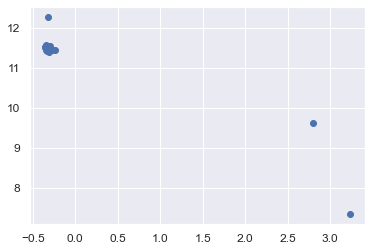

In [80]:
plt.scatter(data_scaled["standardized_regional_prevalence"], data_scaled["standardized_weekly_prevalence"])

2. standardized regional prevalence vs tests per residents

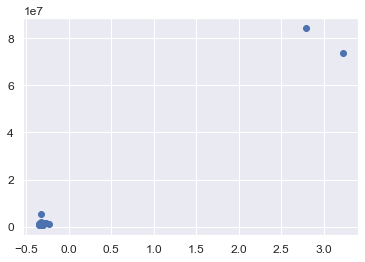

In [81]:
plt.scatter(data_scaled["standardized_regional_prevalence"], data_scaled["Tests_per_residents2021"])

3. standardized weekly prevalence vs tests per residents

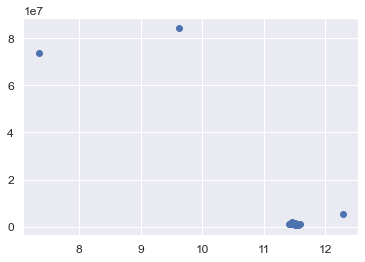

In [82]:
plt.scatter(data_scaled["standardized_weekly_prevalence"], data_scaled["Tests_per_residents2021"])

From the scatterplot it is possible to see that there are three main clusters. 
Let's see whether it is visible a path considering a matrixplot

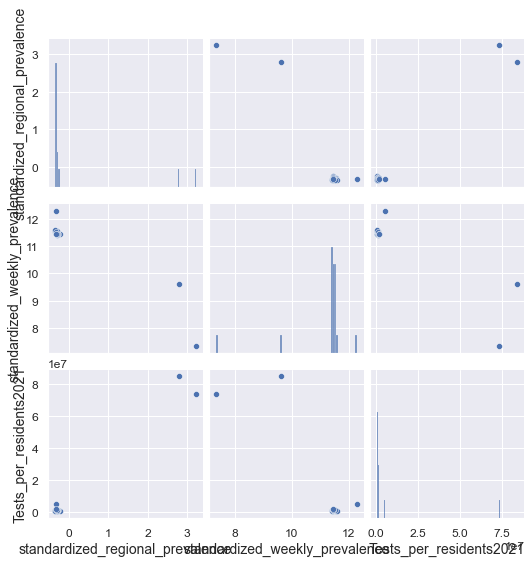

In [83]:
sns.pairplot(pd.DataFrame(data_scaled))

No clear trend is visible.

<a class="anchor" id="dendogram"></a>
#### Dendogram

Let’s first draw the dendrogram to help us decide the number of clusters for this particular problem.

First, to have the regions in the label we have to transform in a list the region names contained in the column Region_name in the df_new dataframe

In [84]:
labels=regions_indexes_df["Region_name"].to_list()
labels

['Abruzzo',
 'Basilicata',
 'Calabria',
 'Campania',
 'Emilia-Romagna',
 'Friuli Venezia Giulia',
 'Lazio',
 'Liguria',
 'Lombardia',
 'Marche',
 'Molise',
 'Piemonte',
 'Puglia',
 'Sardegna',
 'Sicilia',
 'Toscana',
 'Trentino-Alto Adige',
 'Umbria',
 "Valle d'Aosta",
 'Veneto']

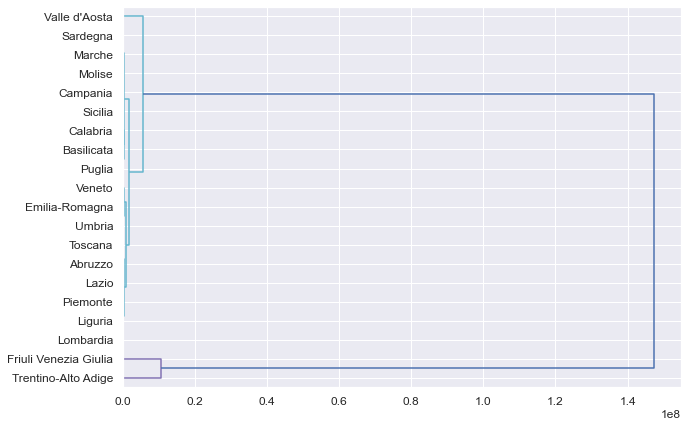

In [85]:
shc.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(10, 7))
regional_dendogram=dendrogram(shc.linkage(data_scaled, method="ward"),
            orientation='right',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig("../plots/regional_dendogram.pdf", bbox_inches="tight")

The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line and hence we can decide a threshold of 0.2 and cut the dendrogram.

Let’s now apply hierarchical clustering for 2 clusters:

In [86]:
cluster = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage='ward')  
preds=cluster.fit_predict(data_scaled)
preds

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

We can see the values of 0s and 1s in the output since we defined 2 clusters. 0 represents the points that belong to the first cluster and 1 represents points in the second cluster. It is possible to notice that just two observations (i.e. two regions) belong to the first cluster and all the others belong to the second cluster. Let’s now visualize the two clusters:

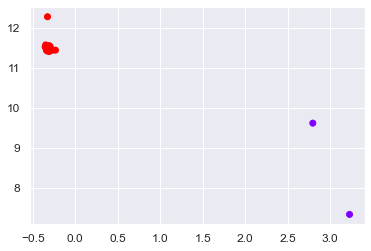

In [87]:
plt.scatter(data_scaled["standardized_regional_prevalence"],data_scaled["standardized_weekly_prevalence"], c=cluster.labels_, cmap='rainbow')

In [88]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = preds
frame['cluster'].value_counts()

1    18
0     2
Name: cluster, dtype: int64

So here we can see the number of observations in each cluster.

<a class="anchor" id="silhouettewidth"></a>
#### Silhouette Width

To have an additional confirmation that two is the optimal number, we compute the average silhouette width.

In [89]:
range_n_clusters = range(2,6)


for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer =AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage='ward') 
    cluster_labels = clusterer.fit_predict(data_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.9763115871676961
For n_clusters = 3 The average silhouette_score is : 0.8894886293320466
For n_clusters = 4 The average silhouette_score is : 0.7625810123872677
For n_clusters = 5 The average silhouette_score is : 0.4921415139771588


If we choose the value which makimizes the silhouette width, the two cluster solution is the optimal one.

<a class="anchor" id="kmeans"></a>

## K-Means

To have a further confirmation of the optimal number of clusers, we also apply the K-Means cluserting technique.

<a class="anchor" id="2clusters"></a>
#### For 2 clusters
We compute k-means considering the value suggested by the silhouette width.

In [90]:
k=2
kmeans1 = KMeans(n_clusters=k, random_state=42, init="random")
y_pred = kmeans1.fit_predict(data_scaled)

In [91]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int32)

In [92]:
kmeans1.cluster_centers_

array([[-3.14144811e-01,  1.15327976e+01,  1.39629125e+06,
         1.00000000e+00],
       [ 3.01011410e+00,  8.48178839e+00,  7.90670559e+07,
         0.00000000e+00]])

<a class="anchor" id="InertiaSilhouette"></a>
#### Inertia and Silhouette Width graph

In [93]:
rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

k_range = range(2,6)

distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(data_scaled)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled,y_km))

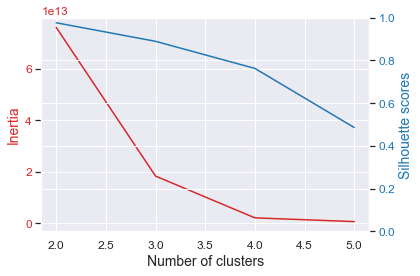

In [94]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("../plots/inertia_plot_regions.pdf", bbox_inches="tight")

Here is is possible to see that the Inertia has an elbow at three clusters, whereas the Silhouette width has the maximum value at k=2. There is also another local maximum for the silhouette line which is at k=4. And the inertia presents another elbow at k=4.

<a class="anchor" id="Kmeansclusterplot"></a>
#### K-Means cluster plots

Now, we display the clusters:

In [95]:
def plot_clusters(data_scaled, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.Set1, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(9) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    plt.figure(figsize=(10,6), dpi=80)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(data_scaled.iloc[y==labels[i],dim[0]], 
                    data_scaled.iloc[y==labels[i],dim[1]], 
                    s=50, 
                    c = [color], # scatter requires a sequence of colors
                    #marker='c', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=60, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show()   

**Regional Prevalence vs Weekly Trend**

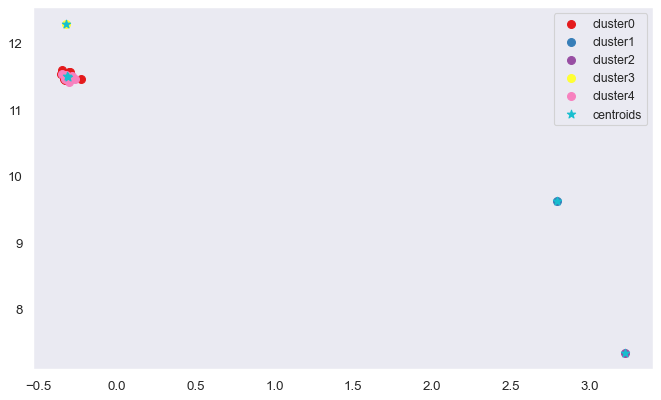

In [96]:

plot_clusters(data_scaled,y_km,dim=(0,1), points = km.cluster_centers_)

***Regional Prevalence vs Tests per residents***

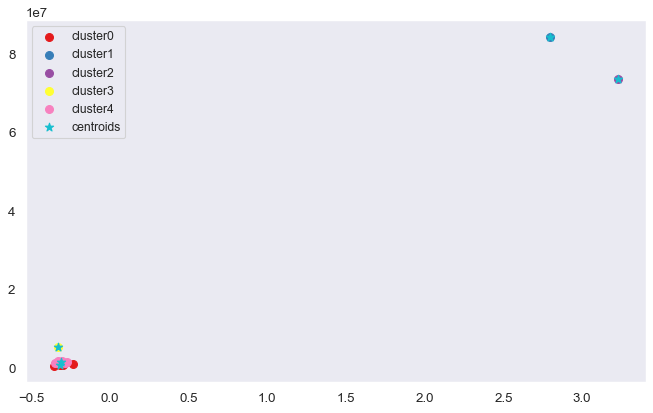

In [97]:
plot_clusters(data_scaled,y_km,dim=(0,2), points = km.cluster_centers_)

***Weekly Trend vs Tests per Residents***

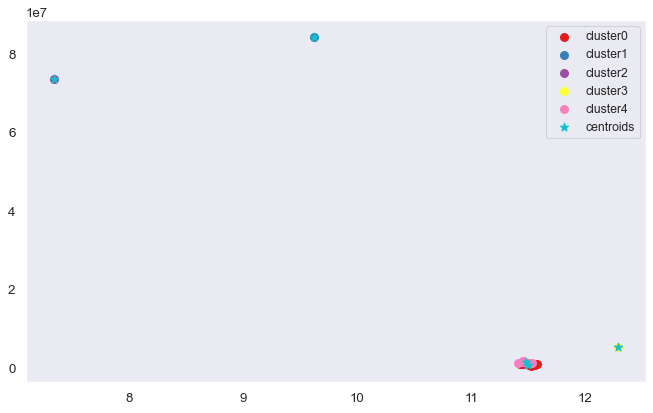

In [98]:
plot_clusters(data_scaled,y_km,dim=(1,2), points = km.cluster_centers_)

<a class="anchor" id="KneeLocator"></a>
#### Knee Locator

In order to detect the elbow, we can use a package called kneed which tries to identify the elbow point of a line to fit the data.

/Users/BeatriceBuselli/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/BeatriceBuselli/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/BeatriceBuselli/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/BeatriceBuselli/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0

Text(0, 0.5, 'Inertia')

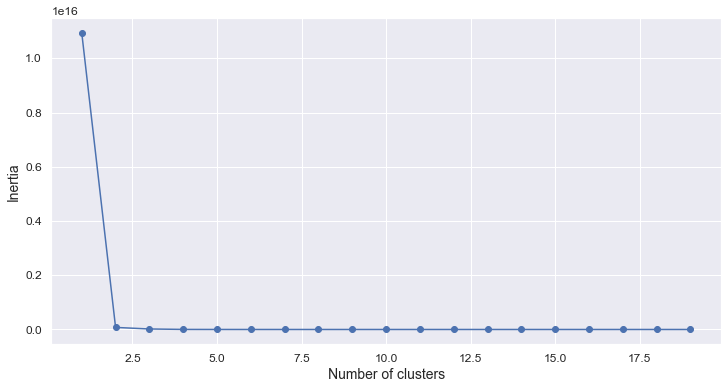

In [99]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [100]:
kl = KneeLocator(range(1, 20), SSE, curve="convex", direction="decreasing")

In [101]:
kl.elbow

2

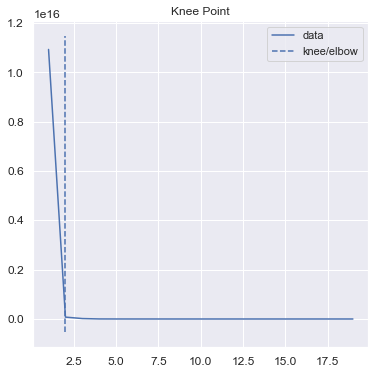

In [102]:
kl.plot_knee()

<a class="anchor" id="KruscalWallis"></a>
## Kruskal Walllis test for intra-cluster variability
The Kruscal Wallis tests tests the null hypothesis that the populaiton median of all of the groups are equal. It is a non-parametric version of the ANOVA. The test works on two or more independent samples, which may have different sizes. 

In [103]:
centroids=kmeans1.cluster_centers_
centroids_cluster1=centroids[0,:]
centroids_cluster2=centroids[1,:]
centroids_cluster2

array([3.01011410e+00, 8.48178839e+00, 7.90670559e+07, 0.00000000e+00])

In [104]:
stats.kruskal(centroids_cluster1,centroids_cluster2)

KruskalResult(statistic=0.08333333333333215, pvalue=0.7728299926844492)

The p-value is not significant, hence we can say that the difference between the medians are not statistically significant. Meaning that the variability in the clusters is quite homogeneous.

<a class="anchor" id="finalconsid"></a>
## Final Considerations

Since the beginning of the analysis, it has been possible to identify two main regions which had values higly different from the other regions. Indeed one of the main thing that is possible to notice is that all the procedures that have been applied to the analysis from the paper's researchers is that all the methods applied are not suitable in presence of outliers. Hence they are non-robust methods, and this can lead to a distortion in the results. For esxample, the Kolmogorov-Smirnov Tests for normality rejected the null hypothesis that the indexes were distributed according to a standard normal distribution, however, in order to be sure that the result was not distorted from the presence of ouliers, either the KS test with the Lilliefois correction or the Shapiro-Wilks test could have been used. Another approach could have been to remove the outliers form the data using an outlier detection rule such as Box Plot or a Robust estimator like the M-estimatior, and recompute the test in order to see wheter the result was different. For the Spearman's rank correlation coeffieint, the MIL (Maximal Information Coefficient) could have been used in order to classify the correlation/relationship between the varaibles. Moreover this method is suitable fro large datasets.

Concerning the clustering procedure, instead of K-Means, PAM or Trimmed K-Means could have been used, since are two methods more robust in presence of outliers. 